This notebook audits for significant changes in the clustering results in the book data, to allow us to detect the significance of shifts from version to version.  It depends on the aligned cluster identities in `isbn-version-clusters.parquet`.

Data versions are indexed by month; versions corresponding to tagged versions also have the version in their name.

We are particularly intersted in the shift in *number* of clusters, and shifts in which cluster an ISBN is associated with (while cluster IDs are not stable across versions, this notebook works on an aligned version of the cluster-ISBN associations).


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

## Load Data

Define the versions we care about:


In [2]:
versions = ['pgsql', '2022-03-2.0', '2022-07', '2022-10', '2022-11-2.1', 'current']

Load the aligned ISBNs:


In [3]:
isbn_clusters = pd.read_parquet('isbn-version-clusters.parquet')
isbn_clusters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43027360 entries, 0 to 43027359
Data columns (total 8 columns):
 #   Column       Dtype  
---  ------       -----  
 0   isbn         object 
 1   isbn_id      int32  
 2   current      float64
 3   2022-11-2.1  float64
 4   2022-10      float64
 5   2022-07      float64
 6   2022-03-2.0  float64
 7   pgsql        float64
dtypes: float64(6), int32(1), object(1)
memory usage: 2.4+ GB


## Cluster Counts

Let's look at the # of ISBNs and clusters in each dataset:


In [4]:
metrics = isbn_clusters[versions].agg(['count', 'nunique']).T.rename(columns={
    'count': 'n_isbns',
    'nunique': 'n_clusters',
})
metrics

,n_isbns,n_clusters
pgsql,24482342,13213677
2022-03-2.0,24503563,13201869
2022-07,32715079,17078096
2022-10,32715078,16882949
2022-11-2.1,33505211,17673075
current,42979427,23191293


## Cluster Size Distributions

Now we're going to look at how the sizes of clusters, and the distribution of cluster sizes and changes.


In [5]:
sizes = dict((v, isbn_clusters[v].value_counts()) for v in versions)
sizes = pd.concat(sizes, names=['version', 'cluster'])
sizes.name = 'size'
sizes

version  cluster    
pgsql    100007751.0    7818
         124319853.0    7520
         100386149.0    6518
         110247989.0    4276
         123212719.0    3712
                        ... 
current  116645882.0       1
         124508765.0       1
         122769739.0       1
         120222596.0       1
         901090064.0       1
Name: size, Length: 101240959, dtype: int64

Compute the histogram:


In [6]:
size_hist = sizes.groupby('version').value_counts()
size_hist.name = 'count'
size_hist

version      size
2022-03-2.0  2       6256782
             1       5807972
             4        551072
             3        268793
             6         96525
                      ...   
pgsql        3712          1
             4276          1
             6518          1
             7520          1
             7818          1
Name: count, Length: 2703, dtype: int64

And plot the cumulative distributions:


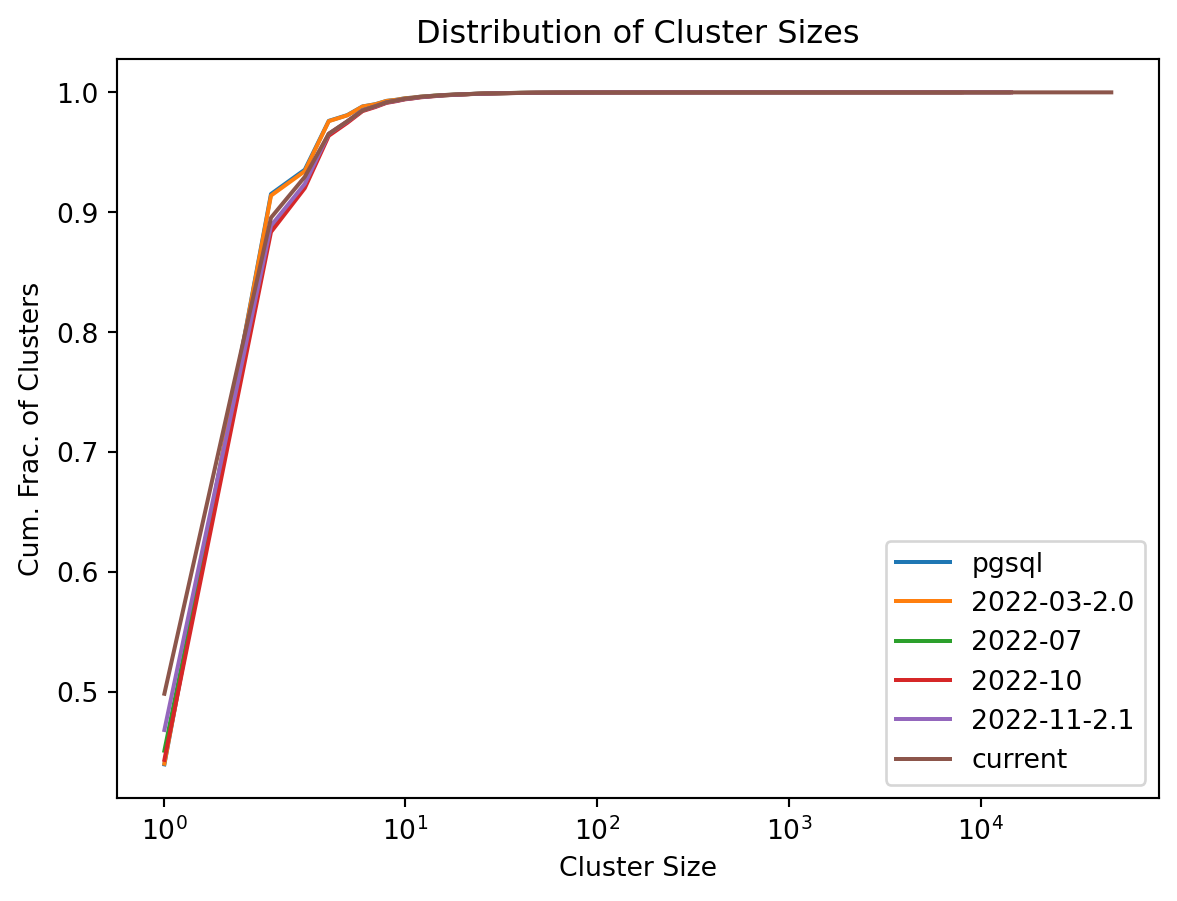

In [7]:
for v in versions:
    vss = size_hist.loc[v].sort_index()
    vsc = vss.cumsum() / vss.sum()
    plt.plot(vsc.index, vsc.values, label=v)

plt.title('Distribution of Cluster Sizes')
plt.ylabel('Cum. Frac. of Clusters')
plt.xlabel('Cluster Size')
plt.xscale('symlog')
plt.legend()
plt.show()

Save more metrics:


In [8]:
metrics['max_size'] = pd.Series({
    v: sizes[v].max()
    for v in versions
})
metrics

,n_isbns,n_clusters,max_size
pgsql,24482342,13213677,7818
2022-03-2.0,24503563,13201869,7976
2022-07,32715079,17078096,13988
2022-10,32715078,16882949,14378
2022-11-2.1,33505211,17673075,14378
current,42979427,23191293,47857


## Different Clusters

### ISBN Changes

How many ISBNs changed cluster across each version?


In [9]:
statuses = ['same', 'added', 'changed', 'dropped']
changed = isbn_clusters[['isbn_id']].copy(deep=False)
for (v1, v2) in zip(versions, versions[1:]):
    v1c = isbn_clusters[v1]
    v2c = isbn_clusters[v2]
    cc = pd.Series('same', index=changed.index)
    cc = cc.astype('category').cat.set_categories(statuses, ordered=True)
    cc[v1c.isnull() & v2c.notnull()] = 'added'
    cc[v1c.notnull() & v2c.isnull()] = 'dropped'
    cc[v1c.notnull() & v2c.notnull() & (v1c != v2c)] = 'changed'
    changed[v2] = cc
    del cc
changed.set_index('isbn_id', inplace=True)
changed.head()

,2022-03-2.0,2022-07,2022-10,2022-11-2.1,current
isbn_id,,,,,
16019319,same,same,same,same,same
13807969,same,same,same,same,added
31809866,same,added,same,same,same
25265130,same,same,same,same,same
39652144,same,added,same,same,same


Count number in each trajectory:


In [10]:
trajectories = changed.value_counts()
trajectories = trajectories.to_frame('count')
trajectories['fraction'] = trajectories['count'] / len(changed)
trajectories['cum_frac'] = trajectories['fraction'].cumsum()

In [11]:
trajectories

count      fraction  \
2022-03-2.0 2022-07 2022-10 2022-11-2.1 current                           
same        same    same    same        same     23838493  5.540310e-01   
                                        added     9488634  2.205256e-01   
            added   same    same        same      8060173  1.873267e-01   
            same    same    added       same       785006  1.824434e-02   
            changed same    same        same       219422  5.099592e-03   
            same    changed same        same       193771  4.503437e-03   
            added   same    same        changed    104536  2.429524e-03   
            same    same    same        changed    101399  2.356617e-03   
added       same    same    same        same        85440  1.985713e-03   
changed     same    same    same        same        42072  9.777965e-04   
dropped     added   same    same        same        41942  9.747751e-04   
            same    same    same        same        23808  5.533224e-04   
same        added   same    same        dropped     13988  3.250955e-04   
            dropped same    same        same         8671  2.015229e-04   
            changed same    same        changed      5180  1.203885e-04   
            same    same    added       changed      4577  1.063742e-04   
changed     changed same    same        same         2733  6.351772e-05   
added       changed same    same        same         1446  3.360652e-05   
same        same    changed same        changed      1149  2.670394e-05   
                    same    same        dropped       988  2.296213e-05   
changed     same    same    same        changed       707  1.643141e-05   
added       same    same    same        changed       703  1.633844e-05   
dropped     same    same    added       same          598  1.389813e-05   
                            same        added         492  1.143458e-05   
same        dropped same    same        added         368  8.552698e-06   
changed     same    changed same        same          254  5.903221e-06   
added       same    same    same        dropped       246  5.717292e-06   
changed     changed same    same        changed       127  2.951610e-06   
added       same    same    dropped     same           92  2.138174e-06   
                    changed same        same           67  1.557149e-06   
same        dropped same    added       same           51  1.185292e-06   
added       dropped same    same        same           49  1.138810e-06   
            changed same    same        changed        30  6.972308e-07   
changed     same    same    same        dropped        29  6.739898e-07   
same        changed same    same        dropped        22  5.113026e-07   
dropped     added   same    same        changed        19  4.415795e-07   
changed     same    changed same        changed        10  2.324103e-07   
            dropped same    same        same           10  2.324103e-07   
same        same    same    added       dropped         8  1.859282e-07   
                            changed     same            6  1.394462e-07   
dropped     added   same    same        dropped         5  1.162051e-07   
same        added   same    dropped     same            5  1.162051e-07   
                    changed same        same            4  9.296410e-08   
changed     same    same    dropped     added           4  9.296410e-08   
added       changed same    dropped     same            4  9.296410e-08   
            dropped same    same        added           3  6.972308e-08   
same        same    same    dropped     same            3  6.972308e-08   
added       changed same    same        dropped         3  6.972308e-08   
changed     dropped same    same        added           2  4.648205e-08   
same        dropped same    added       changed         2  4.648205e-08   
added       same    same    dropped     added           1  2.324103e-08   
same        added   changed same        changed         1  2.324103e-08   
ch

In [12]:
metrics['new_isbns'] = (changed[versions[1:]] == 'added').sum().reindex(metrics.index)
metrics['dropped_isbns'] = (changed[versions[1:]] == 'dropped').sum().reindex(metrics.index)
metrics['changed_isbns'] = (changed[versions[1:]] == 'changed').sum().reindex(metrics.index)
metrics

,n_isbns,n_clusters,max_size,new_isbns,dropped_isbns,changed_isbns
pgsql,24482342,13213677,7818,NaN,NaN,NaN
2022-03-2.0,24503563,13201869,7976,88086.0,66865.0,45950.0
2022-07,32715079,17078096,13988,8220673.0,9157.0,228969.0
2022-10,32715078,16882949,14378,0.0,1.0,195258.0
2022-11-2.1,33505211,17673075,14378,790244.0,111.0,7.0
current,42979427,23191293,47857,9489505.0,15289.0,218442.0


The biggest change is that the July 2022 update introduced a large number (8.2M) of new ISBNs.  This update incorporated more current book data, and changed the ISBN parsing logic, so it is not surprising.

Let's save these book changes to a file for future re-analysis:


In [13]:
changed.to_parquet('isbn-cluster-changes.parquet', compression='zstd')

## Final Saved Metrics

Now we're going to save this metric file to a CSV.


In [14]:
metrics.index.name = 'version'
metrics

,n_isbns,n_clusters,max_size,new_isbns,dropped_isbns,changed_isbns
version,,,,,,
pgsql,24482342,13213677,7818,NaN,NaN,NaN
2022-03-2.0,24503563,13201869,7976,88086.0,66865.0,45950.0
2022-07,32715079,17078096,13988,8220673.0,9157.0,228969.0
2022-10,32715078,16882949,14378,0.0,1.0,195258.0
2022-11-2.1,33505211,17673075,14378,790244.0,111.0,7.0
current,42979427,23191293,47857,9489505.0,15289.0,218442.0


In [15]:
metrics.to_csv('audit-metrics.csv')